# some needed repeted steps from privious file

 # Data Pre-Processing

#### Import Packages and CSV

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", 100)
# Create Dataframe
df = pd.read_csv('marketing_campaign.csv', sep='\t')
# Print shape of dataset
print(df.shape)

(2240, 29)


## Data Cleaning

### Handling Missing values

* Handling Missing values 
* Handling Duplicates
* Check data type
* Understand the dataset

#### Check Null Values

In [121]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Income 1.07143 % missing values


In [122]:
# statistics on numerical columns (Null cols)
df[features_with_na].select_dtypes(exclude='object').describe()

,Income
count,2216.000000
mean,52247.251354
std,25173.076661
min,1730.000000
25%,35303.000000
50%,51381.500000
75%,68522.000000
max,666666.000000


### Imputing Null values

* **Impute Median value for Income column**
- **Why we are using Median instead of Mean or Mode?**
    - The median is the most informative measure of central tendency for skewed distributions or distributions with outliers. For example, the median is often used as a measure of central tendency for income distributions, which are generally highly skewed

In [123]:
#Age
df.Income.fillna(df.Income.median(), inplace=True)

### 3.2 Other Data Cleaning steps

**Handling Duplicates**

In [124]:
df.duplicated().sum()

np.int64(0)

**Remove ```Z_CostContact``` and ```Z_Revenue``` columns from the dataset as contains only constant value, therefore doesn't create any variance in the dataset.**


In [125]:
columns_to_drop = ['ID', 'Z_CostContact','Z_Revenue']
for column in columns_to_drop:
    df.drop(column, inplace=True, axis=1)
    print(f"Column {column} is dropped.")

Column ID is dropped.
Column Z_CostContact is dropped.
Column Z_Revenue is dropped.


# Feature Engineering / Feature extraction

### We'll repeat some steps from EDA
### The following code creates features that would be helpful to describe the profile of the customer 


In [126]:
# create new column for feature

from datetime import datetime


df = df.copy()

##  creating a new field to store the Age of the customer
df['Age']=2022-df['Year_Birth']   

###  recoding the customer's education level to numeric form (0: high-school, 1: diploma, 2: bachelors, 3: masters, and 4: doctorates)
df["Education"].replace({"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4},inplace=True)  

#  recoding the customer's marital status to numeric form (0: not living with a partner, 1: living with a partner) 
df['Marital_Status'].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0,"Alone":0},inplace=True) 

#  creating a new field to store the number of children in the household
df['Children']=df['Kidhome']+df['Teenhome']

#creating Family_Size
df['Family_Size']=df['Marital_Status']+df['Children']+1



#  creating a new field to store the total spending of the customer
df['Total_Spending']=df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df["Total Promo"] =  df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]

## The following code works out how long the customer has been with the company and store the total number of promotions the customers responded to
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'], format="%d-%m-%Y")
today=datetime.today()
df['Days_as_Customer']=(today-df['Dt_Customer']).dt.days
df['Offers_Responded_To']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['Response']
df["Parental Status"] = np.where(df["Children"] > 0, 1, 0)






#dropping columns which are already used to create new features
columns_to_drop = ['Year_Birth','Kidhome','Teenhome']
df.drop(columns = columns_to_drop, axis = 1, inplace=True)
df.rename(columns={"Marital_Status": "Marital Status","MntWines": "Wines","MntFruits":"Fruits",
                   "MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets",
                   "MntGoldProds":"Gold","NumWebPurchases": "Web","NumCatalogPurchases":"Catalog",
                   "NumStorePurchases":"Store","NumDealsPurchases":"Discount Purchases"},
          inplace = True)

df = df[["Age","Education","Marital Status","Parental Status","Children","Income","Total_Spending","Days_as_Customer","Recency","Wines","Fruits","Meat","Fish","Sweets","Gold","Web","Catalog","Store","Discount Purchases","Total Promo","NumWebVisitsMonth"]]


### Type of Features

**Numeric Features**

In [127]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 21


**Categorical Features**

In [128]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 0


**Discrete Features**

In [129]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 10


**Continues Features**

In [130]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 11


**Why scaling comes BEFORE clustering?**

Clustering (KMeans, DBSCAN, Hierarchical) is distance-based

Scaling is mandatory

No data leakage concept here because:

No target exists yet

No prediction is happening

## Feature Transformation & feature scaling

In [131]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
outlier_features = ["Wines","Fruits","Meat","Fish","Sweets","Gold","Age","Total_Spending"] #we can find the columns which has oitliers in the EDA
numeric_features = [x for x in numeric_features if x not in outlier_features]

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


dataC = df.copy()

numeric_pipeline = Pipeline(steps=
                            [("Imputer", SimpleImputer(strategy='constant', fill_value=0)), 
                             ("StandardScaler", StandardScaler())]
                           )

preprocessor = ColumnTransformer(
    [
        ("numeric pipeline",numeric_pipeline, numeric_features),
    ]
)

dataC = preprocessor.fit_transform(dataC)
scaled_data = pd.DataFrame(dataC, columns= numeric_features )
print("After scaling, let's have a glimpse of the scaled dataset :")
scaled_data.head()

After scaling, let's have a glimpse of the scaled dataset :


,Education,Marital Status,Parental Status,Children,Income,Days_as_Customer,Recency,Web,Catalog,Store,Discount Purchases,Total Promo,NumWebVisitsMonth
0,-0.458383,-1.346874,-1.584605,-1.264505,0.235696,1.531185,0.307039,1.409304,2.510890,-0.550785,0.349414,-0.439037,0.693904
1,-0.458383,-1.346874,0.631072,1.396361,-0.235454,-1.190545,-0.383664,-1.110409,-0.568720,-1.166125,-0.168236,-0.439037,-0.130463
2,-0.458383,0.742460,-1.584605,-1.264505,0.773999,-0.205773,-0.798086,1.409304,-0.226541,1.295237,-0.685887,-0.439037,-0.542647
3,-0.458383,0.742460,0.631072,0.065928,-1.022355,-1.061881,-0.798086,-0.750450,-0.910898,-0.550785,-0.168236,-0.439037,0.281720
4,1.533425,0.742460,0.631072,0.065928,0.241888,-0.953012,1.550305,0.329427,0.115638,0.064556,1.384715,-0.439037,-0.130463


In [133]:
joblib.dump(preprocessor, "scaler.pkl")

['scaler.pkl']

### Model Building ( Clustering )

We know that our dataset it unsupervised, that means we don't have such target column. So we will be using clustering algorithms first to cluster the dataset and create target levels out of it. 

Here for Clustering Problem statement, 3 Algorithms are used.

- K-Means Clustering
- Agglomerative Clustering
- DBSCAN

### Create a function for Silhouette score plot

In [134]:
# this function we take it from sklearn page for ploting silhouette with little Modification 
#ploting silhouette_plot aside with clustring results in PCA
from sklearn.metrics import silhouette_score,silhouette_samples
from matplotlib import cm

#silhouette_plot(KMeans,range(3,7), pcadf, reduced)
def silhouette_plot(model,range_n_clusters,X_clustering,pca,**kwargs):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        #ax1 and ax2 are axes objects that represent individual plot areas:
        #ax1: Left subplot - Shows the silhouette plot
        #ax2: Right subplot - Shows the cluster visualization
        #Each axes object (ax1, ax2) has its own:
        #Title (set with ax1.set_title())
        #Labels (set with ax1.set_xlabel(), ax1.set_ylabel())
        #Data (plotted with ax1.plot(), ax2.scatter(), etc.)
        #Customization options (limits, ticks, etc.)
        fig.set_size_inches(18, 7)


        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_clustering) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model(n_clusters,**kwargs)
        cluster_labels = clusterer.fit_predict(X_clustering)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_clustering, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_clustering, cluster_labels)

        y_lower = 10
        
        for i in range(n_clusters):#for each silhouette plot of cluster i
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            # i represents the cluster label (0, 1, 2, ..., n_clusters-1)
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            #This variable contains all the silhouette scores of the samples that belong to the i-th cluster.
            #If cluster 0 has 50 samples → then ith_cluster_silhouette_values is an array of 50 silhouette scores.
            #when we apply .shape on array(ith_cluster_silhouette_values`) it will give ua an tuple(), if array is 2D it will gives (x,y) & if 1D it give(x,) 
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, ## x-coordinate (slightly left of y-axis)
                     y_lower + 0.5 * size_cluster_i,## y-coordinate (middle of cluster's bars)
                     str(i))## text to display (cluster number)


            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
    #     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        sns.scatterplot(
            x = pca[:, 0],
            y = pca[:, 1],
            hue=cluster_labels,
            palette=sns.color_palette("colorblind", len(set(cluster_labels))),
            alpha=0.7,
            legend="full",
            ax = ax2
        )
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for {model.__name__} clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

## PCA (Principal Component Analysis)
There is many high correlation feature so we will use some dimentinality reduction. 
We can use PCA

* **each Principal Component is actually a vector that points in the direction of maximum variance.**

### Choosing PCA` n_components` and Kmeans `n_clusters` based on Clustering metrics

In [135]:
# apply PCA and display clustering metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

for y in range(2, 8):
    print("PCA with # of components: ", y)
    pca = PCA(n_components=y)
    data_p = pca.fit_transform(dataC)
    for x in range(2, 7):
        kmeans = KMeans(n_clusters = x,)
        label = kmeans.fit_predict(data_p)#They tell the silhouette function which cluster each point belongs to.
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(data_p, label) , '-  Inertia: ',kmeans.inertia_)
        #Inertia in KMeans >> “How tightly the points in each cluster are grouped around their center.”
    print()

PCA with # of components:  2
Silhouette-Score for 2 Clusters:  0.4557387795357149 -  Inertia:  6400.664895954907
Silhouette-Score for 3 Clusters:  0.501983439645709 -  Inertia:  3469.128400648483
Silhouette-Score for 4 Clusters:  0.47092904902620014 -  Inertia:  2792.465164993986
Silhouette-Score for 5 Clusters:  0.3861225347405721 -  Inertia:  2365.3404837211756
Silhouette-Score for 6 Clusters:  0.35864387977045453 -  Inertia:  2071.160586710312

PCA with # of components:  3
Silhouette-Score for 2 Clusters:  0.3735717781859896 -  Inertia:  9133.55236045909
Silhouette-Score for 3 Clusters:  0.38889470670620757 -  Inertia:  6181.580760727234
Silhouette-Score for 4 Clusters:  0.3448635345615244 -  Inertia:  5169.898340595129
Silhouette-Score for 5 Clusters:  0.32111670654779284 -  Inertia:  4455.1749931780705
Silhouette-Score for 6 Clusters:  0.2969660260792089 -  Inertia:  4033.475382473658

PCA with # of components:  4
Silhouette-Score for 2 Clusters:  0.33371661586333884 -  Inertia:  

**Report**
* **We can go with PCA with 2 components.**
* **We can go with Kmeans Clusters in the range of 4-6 as it has Good score with lesser Inertia compared to others**

So, lower inertia → points are closer to their cluster center → better clustering.

| Term                 | Meaning                                      | Ideal Value          |
| :------------------- | :------------------------------------------- | :------------------- |
| **Inertia**          | How close points are to their cluster center | **Lower is better**  |
| **Silhouette Score** | How well-separated and compact clusters are  | **Higher is better** |

In [136]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=2,random_state=42)

reduced=pca_final.fit_transform(dataC)#it will give us an numpy array.
pcadf = pd.DataFrame(reduced) 
pcadf.columns = ['PC1', 'PC2'] 
  
pcadf.head(10)

,PC1,PC2
0,1.870359,0.891390
1,-1.763568,-1.137896
2,2.218978,-0.199202
3,-1.599894,-1.115108
4,-0.230226,1.097784
5,0.516088,1.030046
6,-0.170621,1.628425
7,-1.556478,0.176569
8,-1.970885,-0.462206
9,-4.561820,-0.373429


##### The explained variance ratio is the percentage of variance that is attributed by each of the selected components.

In [137]:
pca_final.explained_variance_ratio_

array([0.2865669 , 0.14534489])

#### Elbow Method to find best Clusters for K-Means


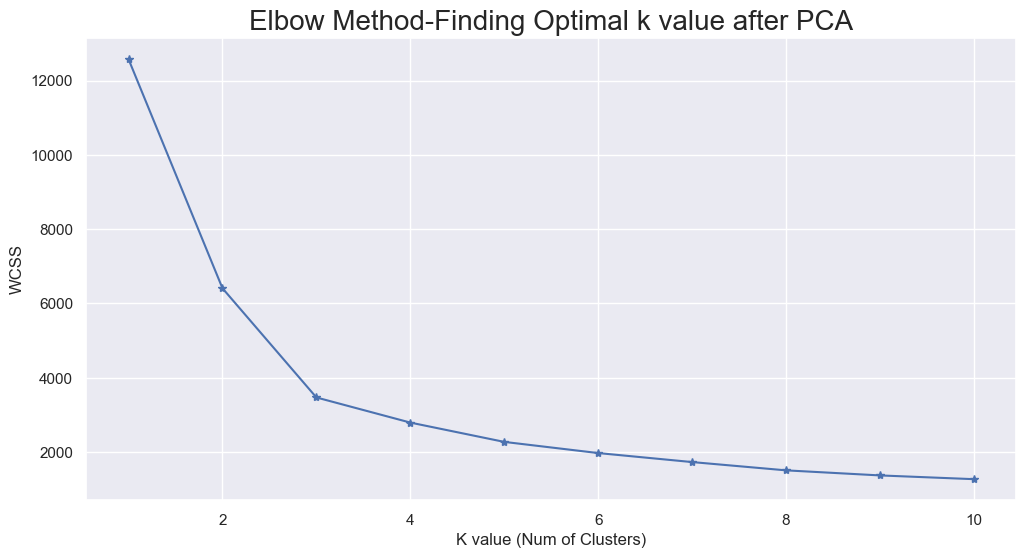

In [138]:
wcss= {}
sns.set()
plt.figure(figsize=(12,6))
for i in range(1,11): 
    km = KMeans(n_clusters=i)
    km.fit(pcadf)
    wcss[i]=km.inertia_

plt.plot(range(1,11),wcss.values(), marker='*')
plt.title('Elbow Method-Finding Optimal k value after PCA', fontsize =20)
plt.xlabel('K value (Num of Clusters)')
plt.ylabel('WCSS')
plt.show()

- Here the optimum number of cluster is 3 cluster since it is the place where the graph start to flatten out meaning that having higher number of cluster will not yield a much more fitting machine.

**Reports:**

* We will use **k = 3**, thus there will be **three clusters** in our dataset.
* We will use **KMeans Algorithm** for clustering.

In [139]:
wcss

{1: 12577.271109028843,
 2: 6409.1643397755915,
 3: 3469.032795282047,
 4: 2792.712899316943,
 5: 2272.76111897879,
 6: 1972.2460927171933,
 7: 1729.7395028553478,
 8: 1506.7155879501433,
 9: 1370.2619581225158,
 10: 1269.3241254619338}

#### Silhoutte Score Plot for K-Means to choose best number of clusters

For n_clusters = 3 The average silhouette_score is : 0.5019577793632544
For n_clusters = 4 The average silhouette_score is : 0.4420328930444256
For n_clusters = 5 The average silhouette_score is : 0.4393285722023918
For n_clusters = 6 The average silhouette_score is : 0.4304965908723589


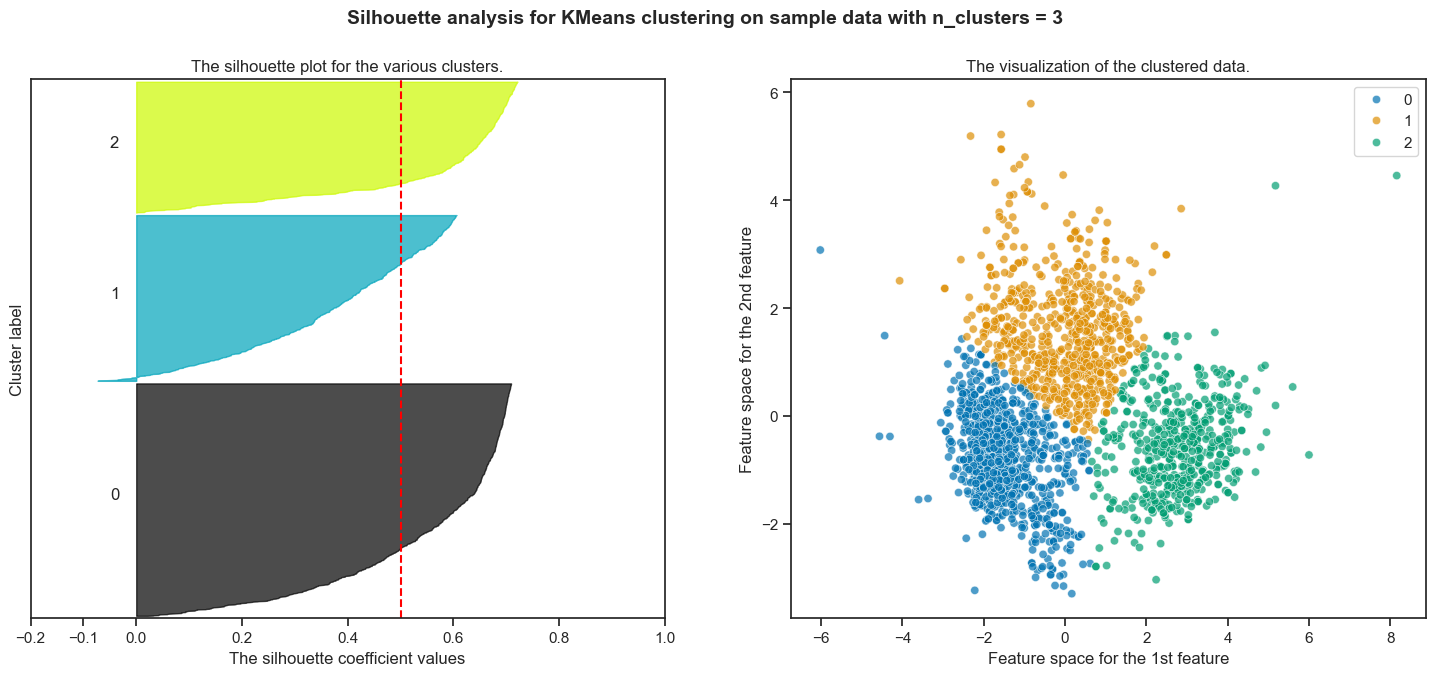

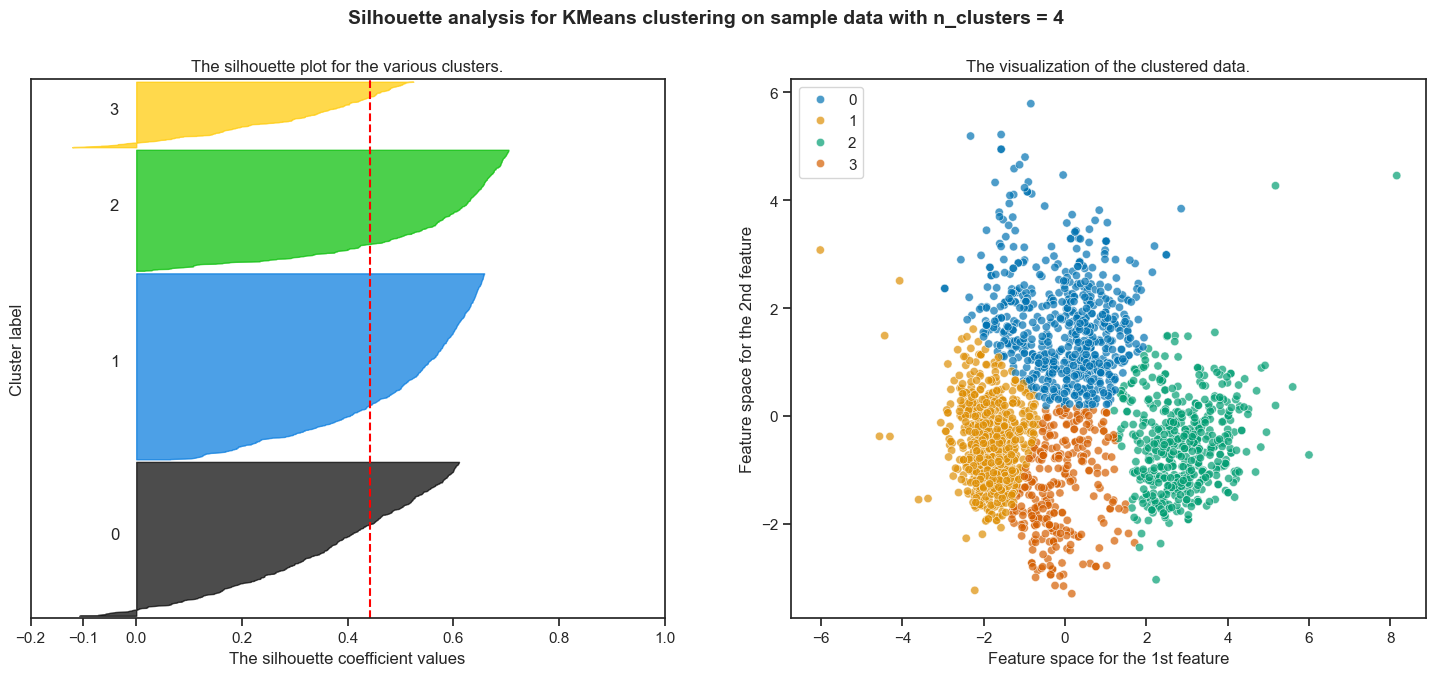

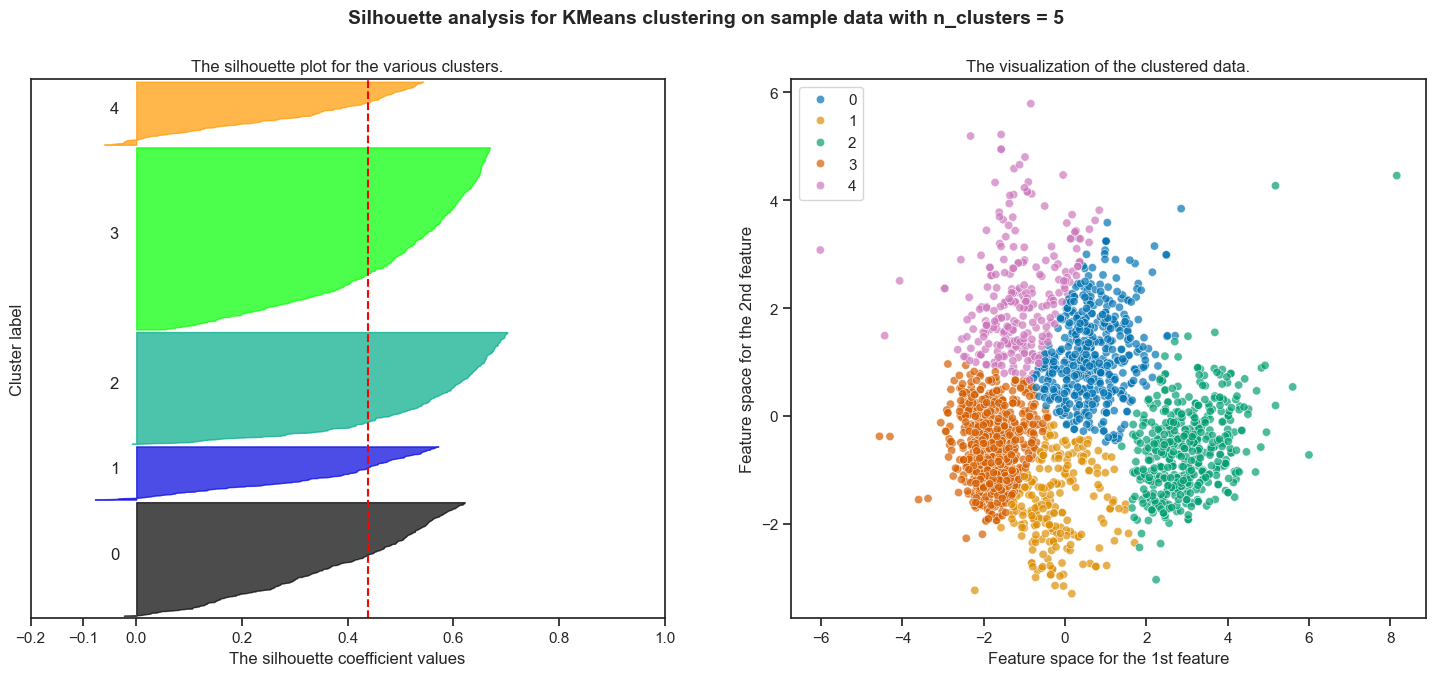

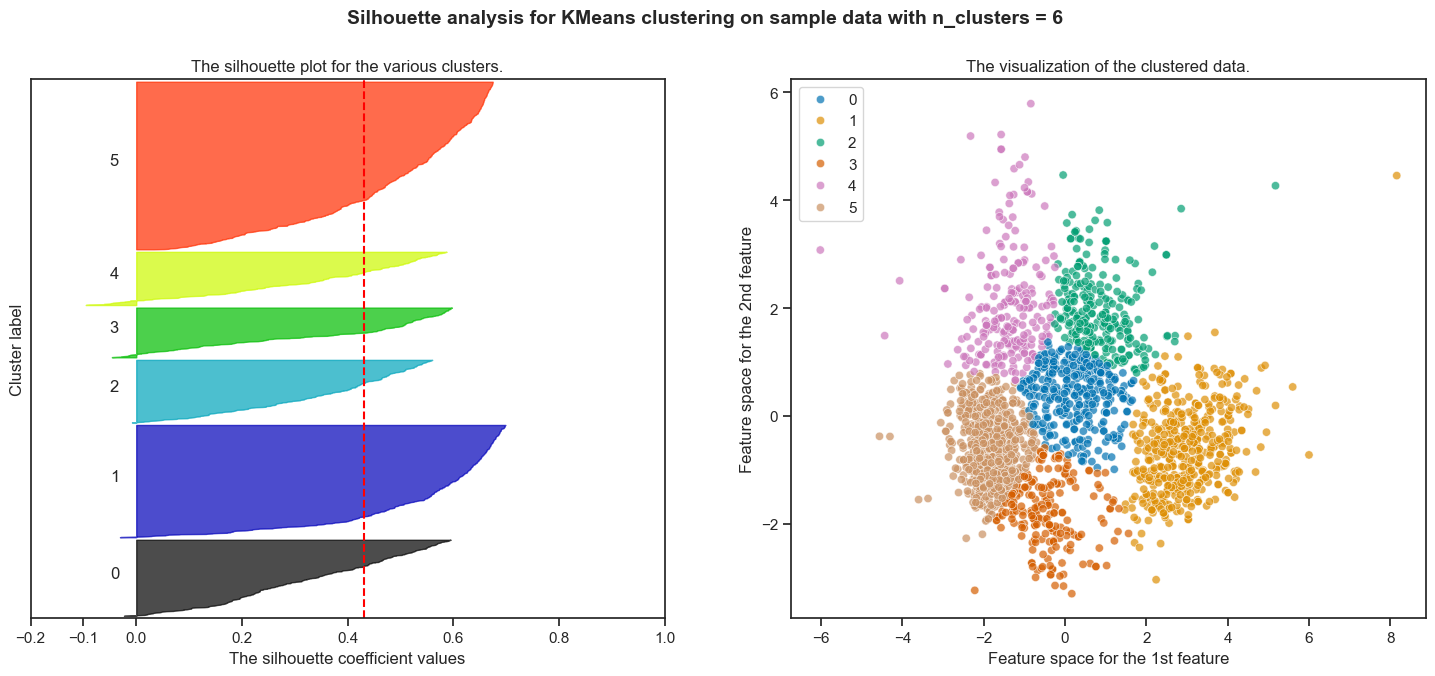

In [140]:
# We plot silhoutte score for Kmeans
# Here pcadf is pca dataframe, and Reduced is array of data after PCA.
sns.set_style('ticks')
silhouette_plot(KMeans,range(3,7), pcadf, reduced)

#### For n_clusters = 3 The average silhouette_score is : 0.5104
#### For n_clusters = 4 The average silhouette_score is : 0.4565
#### For n_clusters = 5 The average silhouette_score is : 0.42996
#### For n_clusters = 6 The average silhouette_score is : 0.390


**Conclusions**
* Clusters of 3 has good balance of Inertia and Shilloute score, we can go with with 3 clusters.


### Apply Kmeans Clustering with 3 clusters

In [141]:
# Fitting the model to reduced data
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

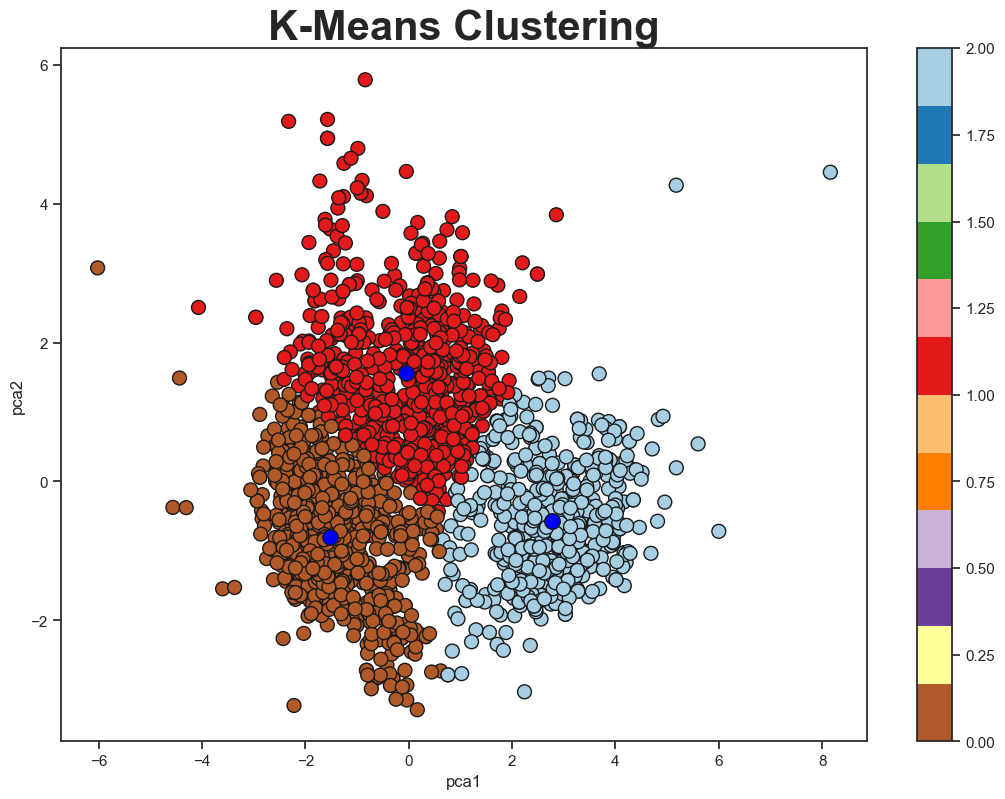

In [142]:
#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label,
                        s=100, 
                        cmap='Paired_r', ec='k')
plt.scatter(model_centers[:,0], model_centers[:,1], c='blue', marker='.',s=500, ec='k')
plt.colorbar(scatter)

### Hierarchical clustering (Agglomerative)


#### Silhoutte Score Plot for Agglomerative Clustering to choose best number of clusters
- We will go with the n_clusters range of 3-7 to find the best cluster for Agglomerative clustering

For n_clusters = 3 The average silhouette_score is : 0.4006049014665729
For n_clusters = 4 The average silhouette_score is : 0.3907742017429038
For n_clusters = 5 The average silhouette_score is : 0.3750607375286338
For n_clusters = 6 The average silhouette_score is : 0.36566274945508753
For n_clusters = 7 The average silhouette_score is : 0.37307031937074514


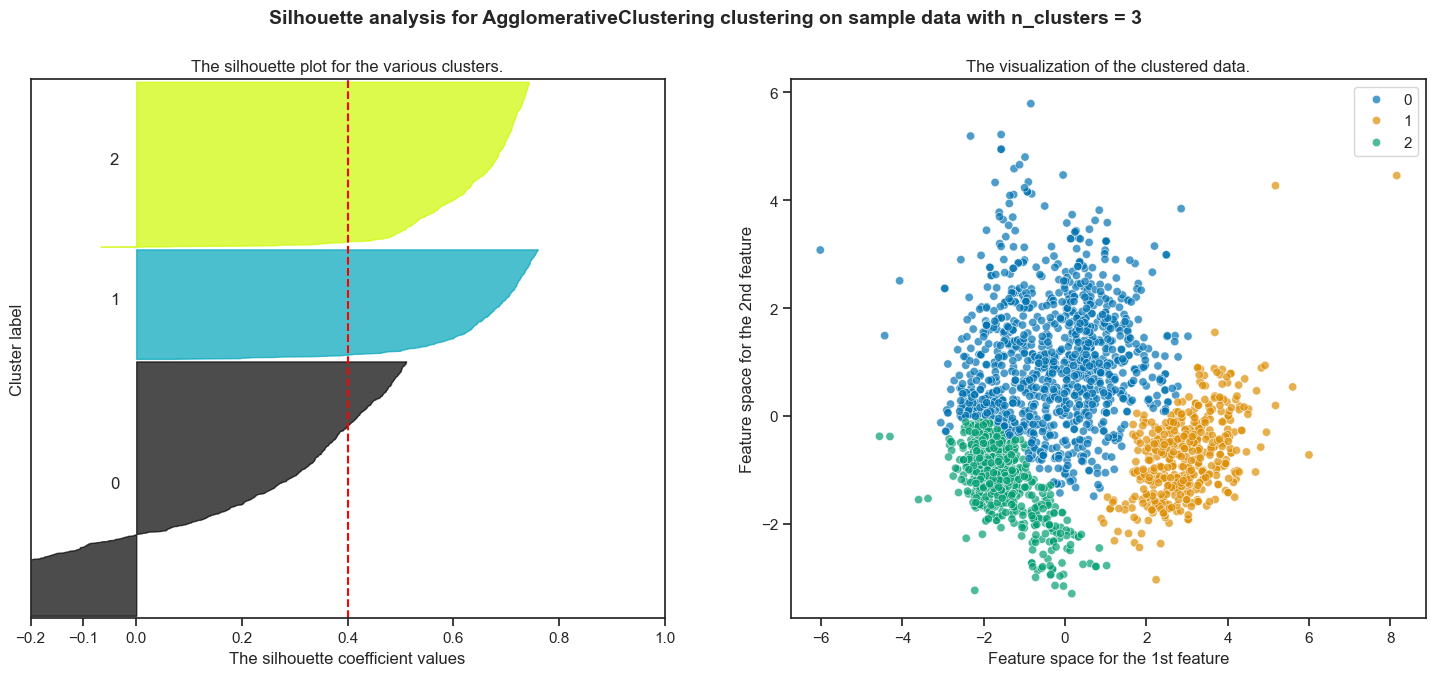

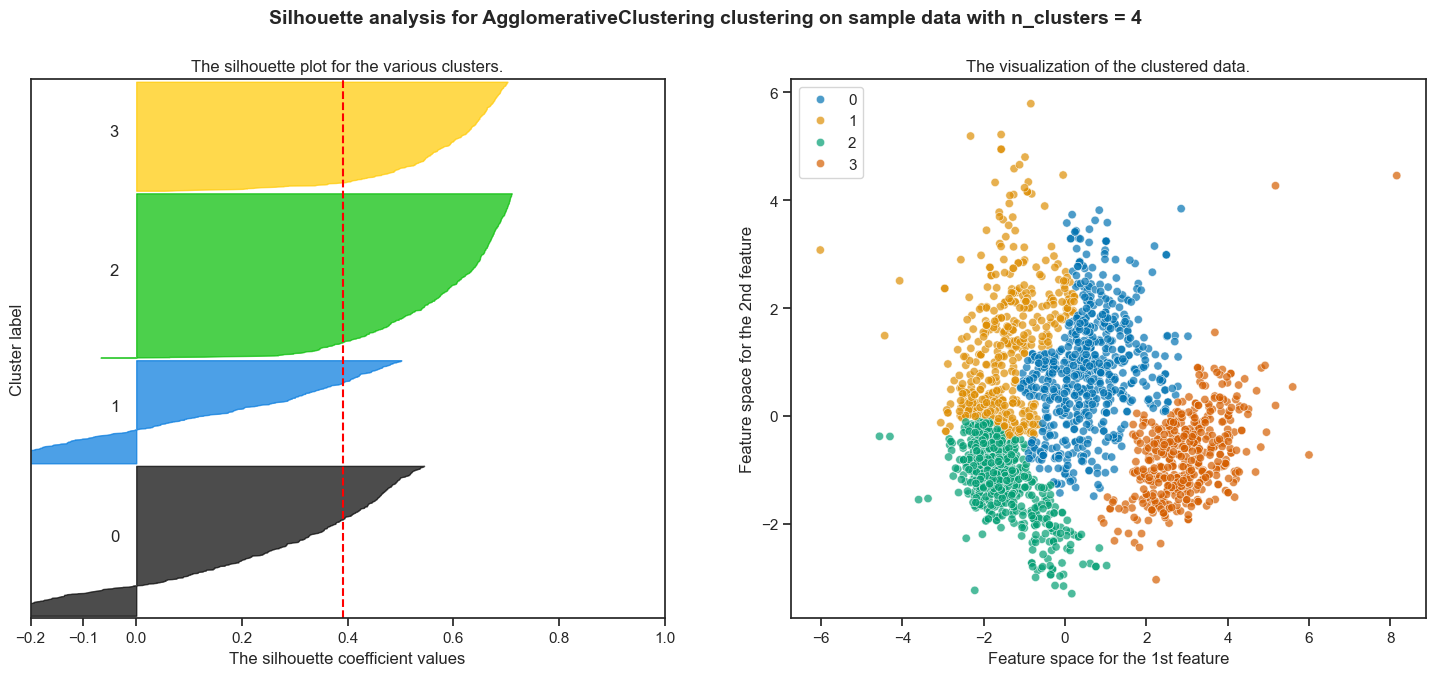

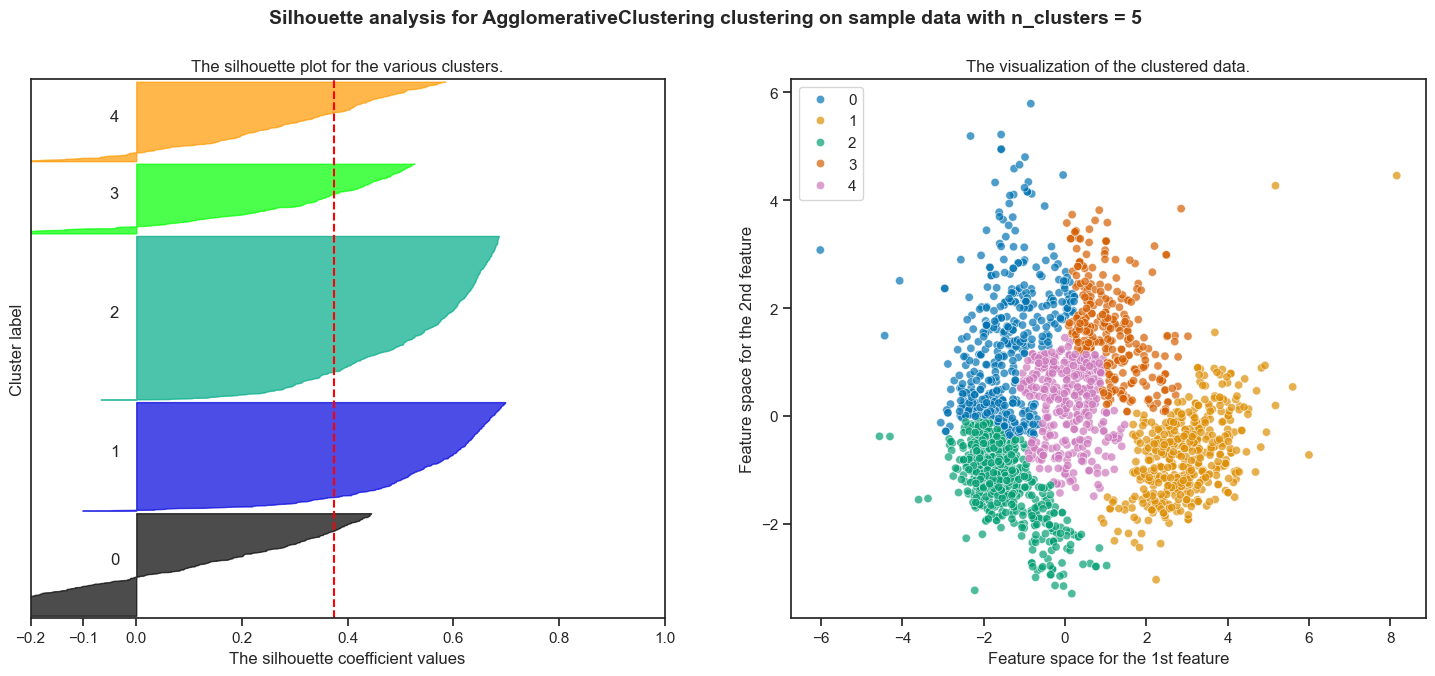

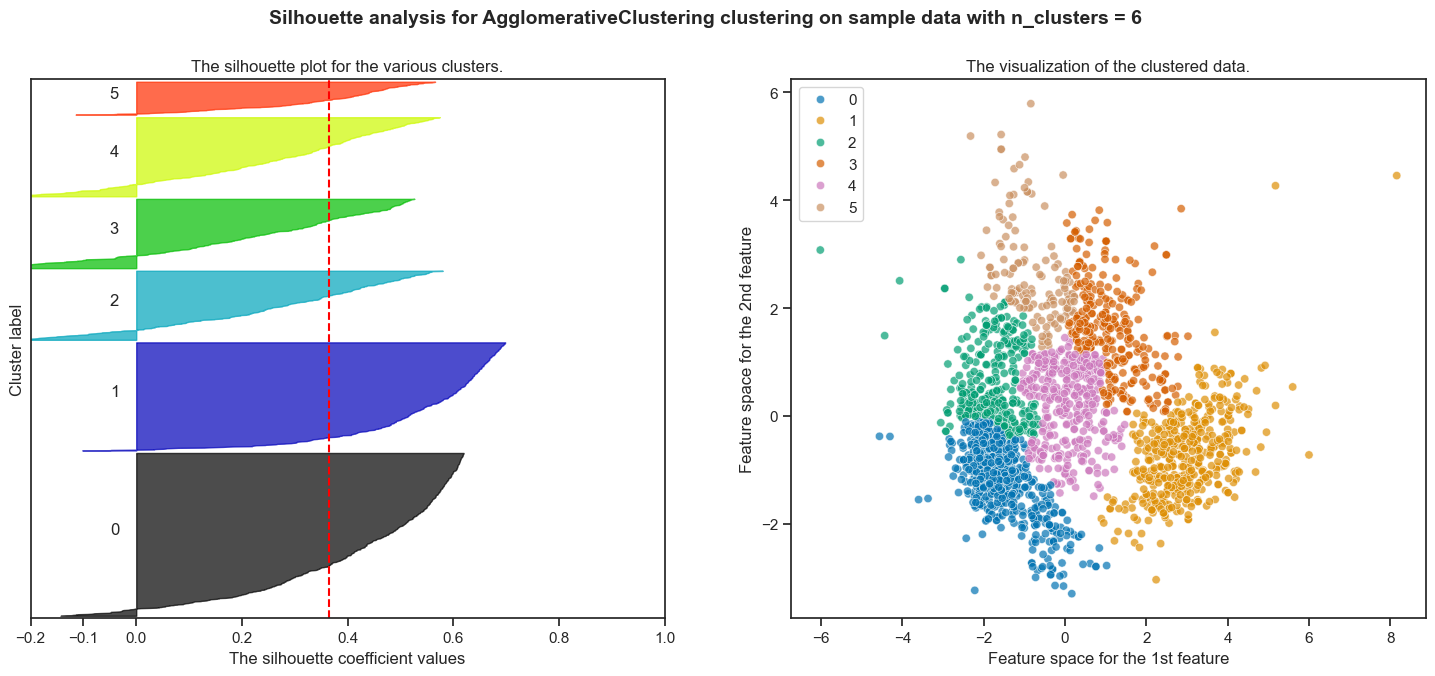

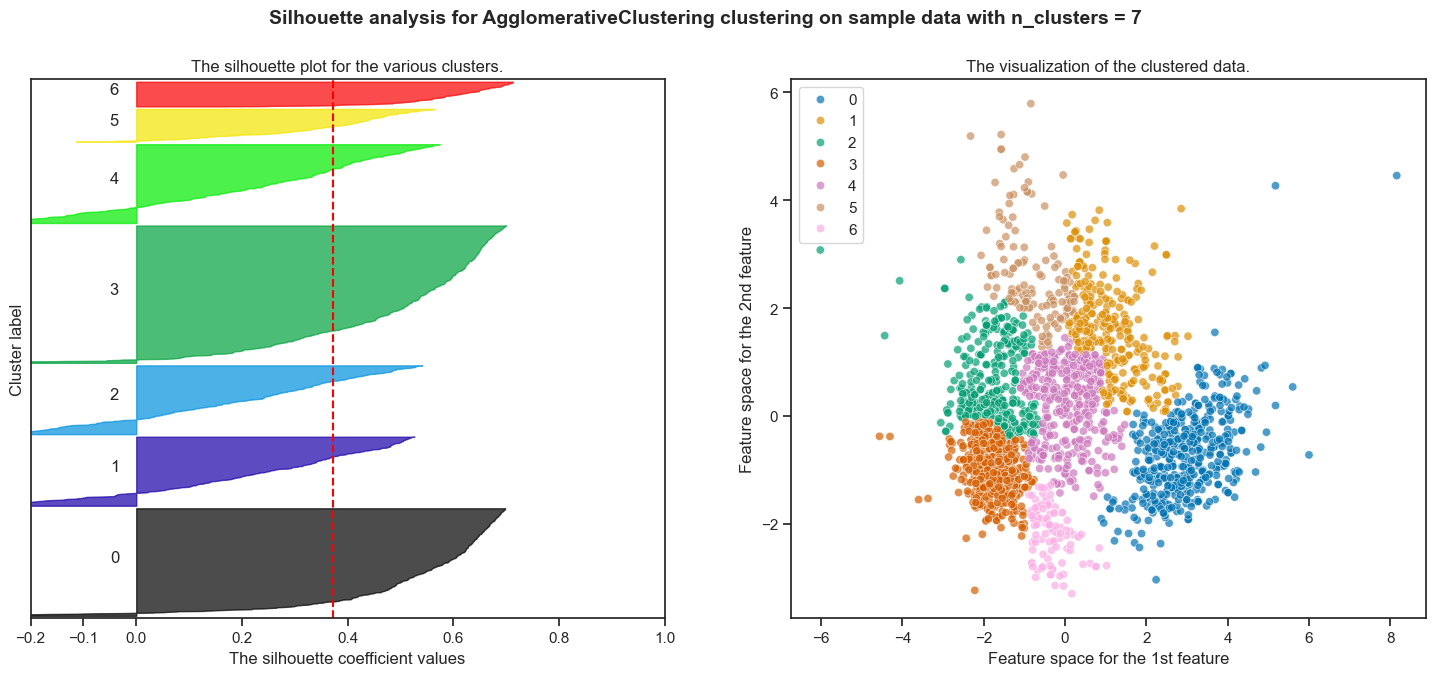

In [143]:
from sklearn.cluster import AgglomerativeClustering
#Plot Score to choose best clusters
silhouette_plot(AgglomerativeClustering,range(3,8),pcadf,reduced)

#### Visualization of Agglomerative Clustering

best average silhouette_score is : 0.479

### For n_clusters = 3 The average silhouette_score is : 0.4793304219958075
### for n_clusters = 4 The average silhouette_score is : 0.4422221719419182
### for n_clusters = 5 The average silhouette_score is : 0.44374523677707167
### for n_clusters = 6 The average silhouette_score is : 0.37663609855276475
### for n_clusters = 7 The average silhouette_score is : 0.38077029061500806


**Conclusions**
* Clusters of 3 has good balance of Inertia and Shilloute score, we can go with with 3 clusters.


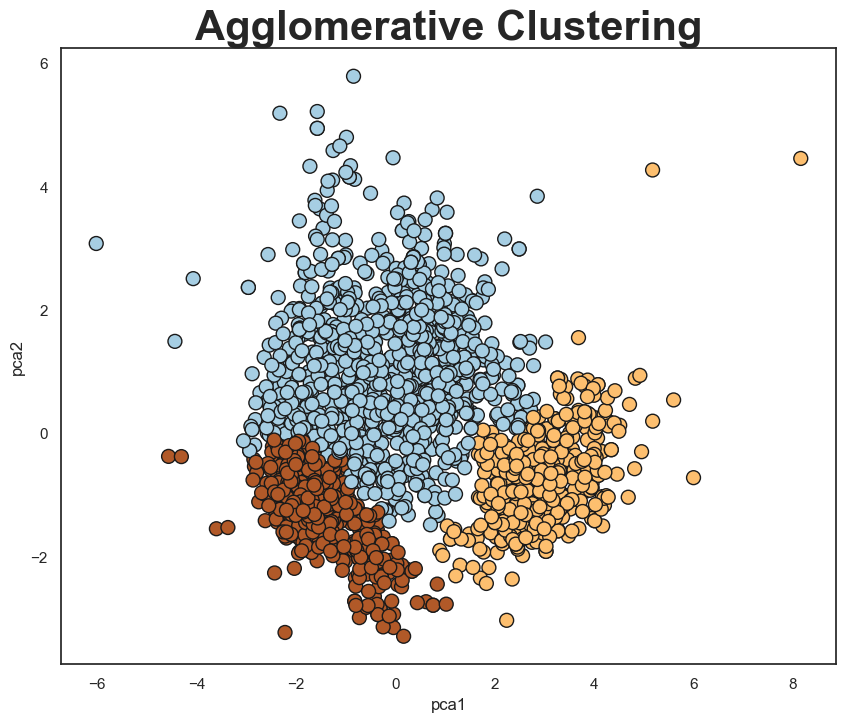

In [144]:
model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward').fit(reduced)
model_label = model.labels_
plt.figure(figsize=(10,8))

sns.set_style('white')
plt.title('Agglomerative Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=100, cmap='Paired', ec='k')

**Report**
* Agglomerative clustering performed well than K means clustering.
* The best Silhoutte score is 0.46, were as K means had 0.44 Silhoutte score.

### DBSCAN Clustering


### Finding the Optimal value of Epsilon

Rather than experimenting with different values of epsilon, we can use the elbow point detection method to arrive at a suitable value of epsilon.

In this approach, the average distance between each point and its k nearest neighbors is calculated where k = the MinPts selected.

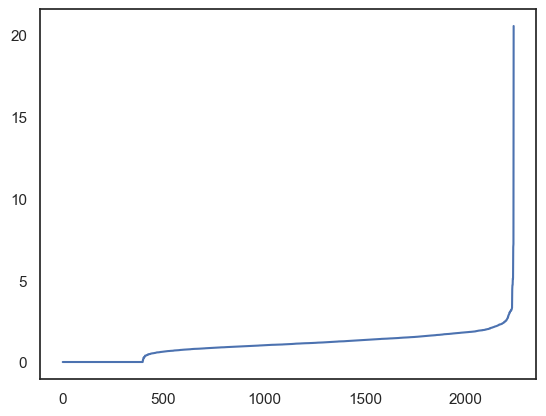

In [145]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

neighbors = NearestNeighbors(n_neighbors=17)
neighbors_fit = neighbors.fit(dataC)
distances, indices = neighbors_fit.kneighbors(dataC)#here indices.shape or distances.shape=(2240,17)
#Now, for each data point, you are finding its 17 nearest neighbors (since you specified n_neighbors=17).


distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

### **Kneedle algorithm**
* We’ll use the Kneedle algorithm here via Kevin Arvai’s excellent Python implementation called Kneed. You can download this via PyPi by entering `pip3 install kneed` into your terminal and then importing the package with `from kneed import KneeLocator`.

  Using cached https://files.pythonhosted.org/packages/9a/1b/7e726d8616e813007874468c61790099ba21493e0ea07561b7d9fc53151c/kneed-0.8.5-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/69/65/0d47953afa0ad569d12de5f65d964321c208492064c38fe3b0b9744f8d44/numpy-1.24.4-cp38-cp38-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/32/8e/7f403535ddf826348c9b8417791e28712019962f7e90ff845896d6325d09/scipy-1.10.1-cp38-cp38-win_amd64.whl


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\program files\\python38\\Lib\\site-packages\\numpy'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


<Figure size 500x500 with 0 Axes>

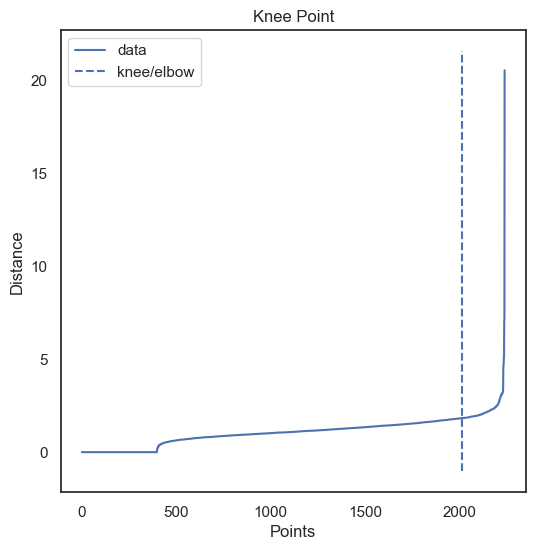

Knee Locator k = 1.830351790877214


In [146]:
!pip install kneed
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= distances[knee.knee]
print('Knee Locator k =', k)

### For 2-dimensional data, use DBSCAN’s default value of MinPts = 4 .

**DBSCAN algorithm works with two parameters.**

These parameters are:

* Epsilon (Eps): This is the least distance required for two points to be termed as a neighbor. This distance is known as Epsilon (Eps). Thus we consider Eps as a threshold for considering two points as neighbors, i.e., if the distance between two points is utmost Eps, then we consider the two points to be neighbors.

* MinPoints: This refers to the minimum number of points needed to construct a cluster. We consider MinPoints as a threshold for considering a cluster as a cluster. A cluster is only recognized if the number of points is greater than or equal to the MinPts.


### Plot using PCA

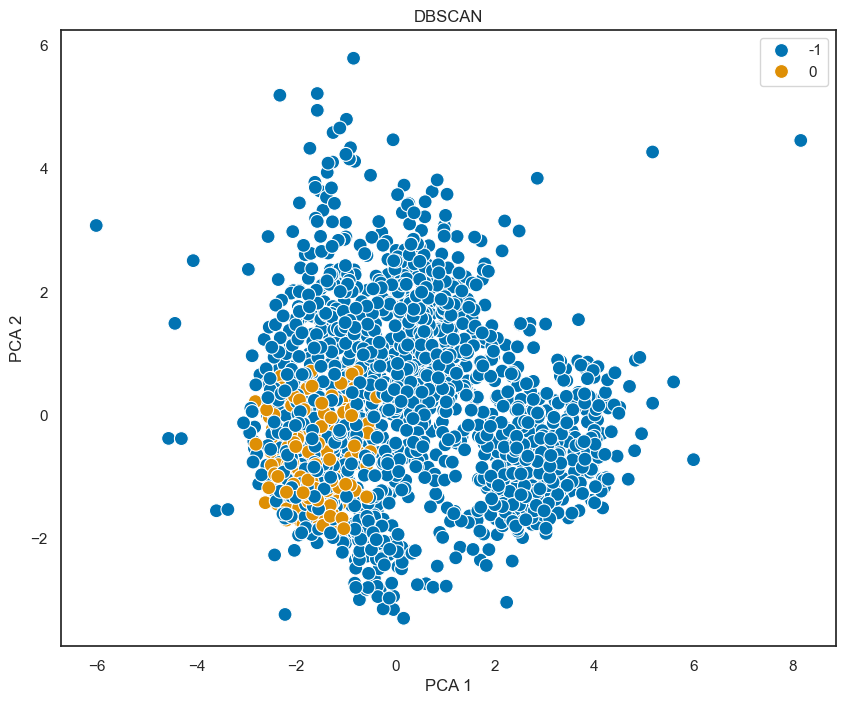

In [147]:
model=DBSCAN(eps=k , min_samples=100).fit(dataC)
model_label = model.labels_
plt.figure(figsize=(10,8))

plt.title('DBSCAN')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
scatter = sns.scatterplot(x = reduced[:,0], y = reduced[:,1], hue= model_label,
                      palette=sns.color_palette("colorblind", len(set(model_label))), s=100)

### DBSCAN didn't perform well in clustering.
- Its clear that DBSCAN does not work to well when we are dealing with clusters of varying densities or with high dimensional data
- DBSCAN does not perform well on the our data that means it is not sutiable for our data, it shows mix up the points in our DBSCAN plot
- our data does not contain that much outliers that we have to use DBSCAN, or any density based approchs

### Final Model

As Kmeans Clustering performed well than rest of the other algorithms, we will go with this

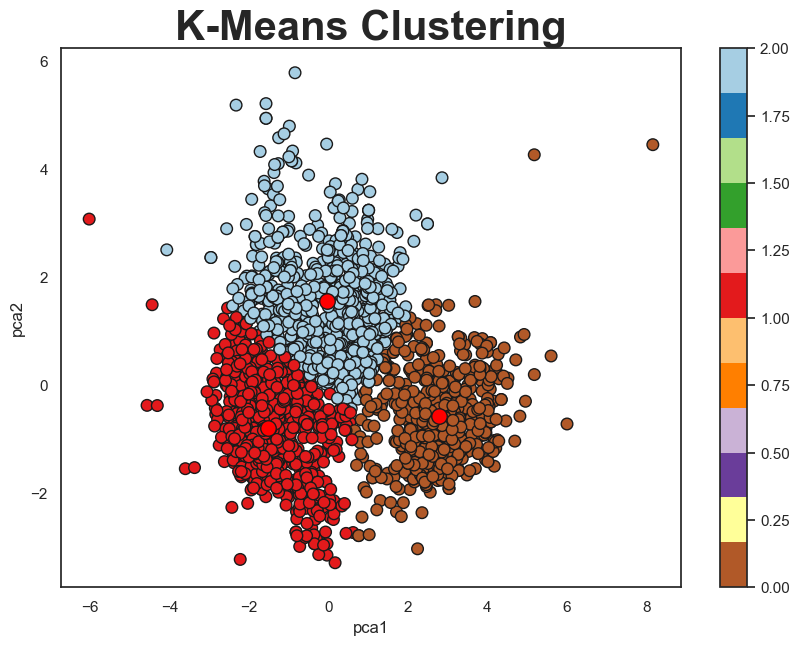

In [148]:

# Fitting the model to reduced data
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

#Plotting the clusters
plt.figure(figsize=(10,7))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k')

### Saving the data with cluster column

In [149]:
import os

# Add cluster labels to dataframe
df["cluster"] = model.labels_.astype(int)

# Save clustered dataset
df.to_csv("clustered_data.csv", index=False)


### Final report
- As we got the EDA results, we used that same approaches here also. We extracted out some features to derive valuable meanings from the data and used those in model training.
- The data had outliers and multicollinearity, We created pipelines to handle those things
- We have used PCA to minimize the dimensionality of the data.
- Kmeans Clustering algorithm has performed better then rest of the other clustering algorithms. So we went with it.